In [1]:
from sklearn.cross_decomposition import CCA
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [2]:
#Load the kinematics for hand and target in the simulation
#The corresponding kinematics file will be saved as test_kinematics_hand(/target)_test_data_filename(in test configs file)

hand_kin = np.load("./kinematics_hand_test.npy")
target_kin = np.load("./kinematics_target_test.npy")

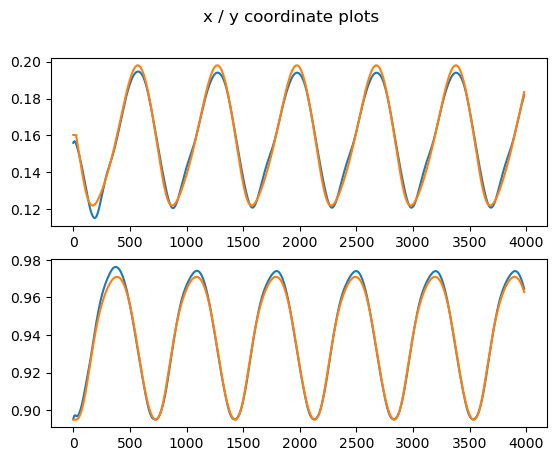

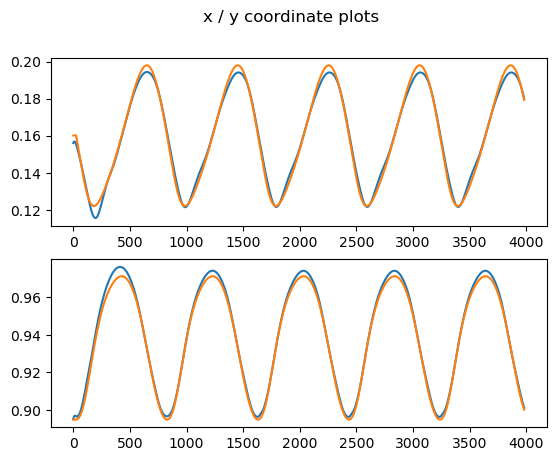

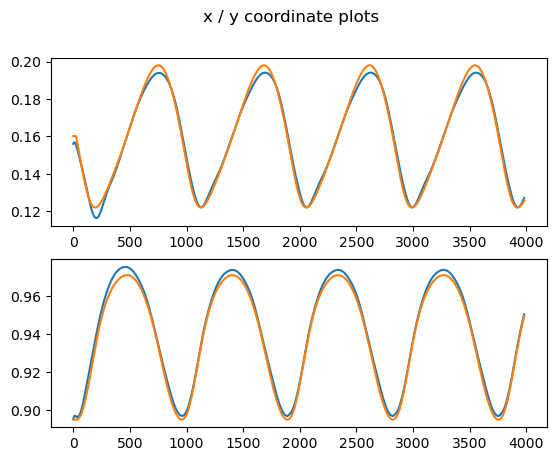

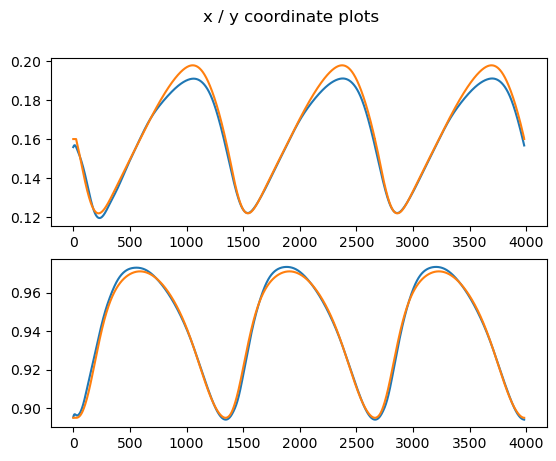

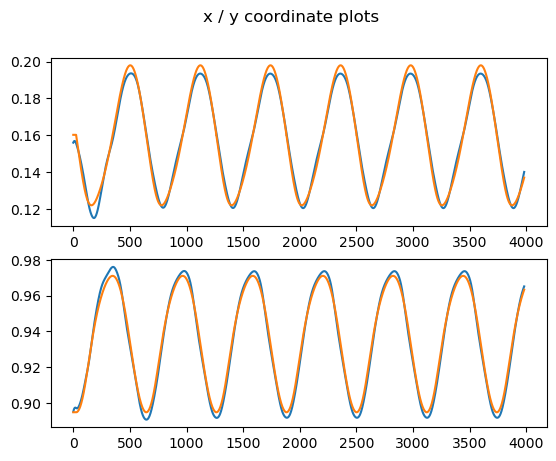

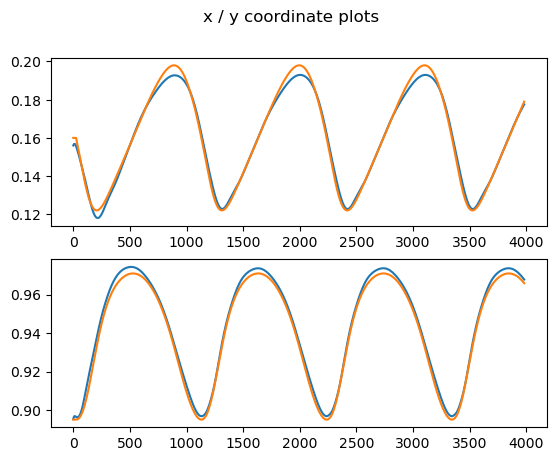

In [3]:
#Plot musim kinematics with targets for easy visualization
#kin shape: [n_test+train_conds, simulation_timepoints, 3]

for i_cond in range(hand_kin.shape[0]):
    #Get the hand and target kinematics for the given condition
    h_x = hand_kin[i_cond, :, 0]
    h_y = hand_kin[i_cond, :, 2]
    
    t_x = target_kin[i_cond, :, 0]
    t_y = target_kin[i_cond, :, 2]
    
    fig, axs = plt.subplots(2)
    fig.suptitle('x / y coordinate plots')
    
    axs[0].plot(h_x)
    axs[0].plot(t_x)
    
    axs[1].plot(h_y)
    axs[1].plot(t_y)
    
    plt.show()

In [4]:
#Load experimental for training and testing

with open("./Neural_Analysis/Training/exp_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    exp_train = pickle.load(file)

with open("./Neural_Analysis/Testing/exp_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    exp_test = pickle.load(file)

    
#Load the nusim activities for training and testing
nusim_activity_train_test = np.load("./hidden_act_test.npy")

nusim_train = {}
for i_cond in range(len(exp_train)):
    nusim_train[i_cond] = nusim_activity_train_test[i_cond]
    #Select timepoints for analysis
    # Skip the first fixed number of timesteps for which the target is constant
    # The fixedsteps should be equal to self.n_fixedsteps in SAC/RL_Framework_Mujoco.py
    nusim_train[i_cond] = nusim_train[i_cond][25+2*exp_train[i_cond].shape[0]:25+3*exp_train[i_cond].shape[0], :]

nusim_test = {}
for i_cond in range(len(exp_test)):
    nusim_test[i_cond] = nusim_activity_train_test[i_cond+len(exp_train)]
    nusim_test[i_cond] = nusim_test[i_cond][25+2*exp_test[i_cond].shape[0]:25+3*exp_test[i_cond].shape[0], :]

In [5]:
#Load emg for training and testing

with open("./Neural_Analysis/Training/emg_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    emg_train = pickle.load(file)

with open("./Neural_Analysis/Testing/emg_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    emg_test = pickle.load(file)

#Load kinematics for training and testing

with open("./Neural_Analysis/Training/kin_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    kin_train = pickle.load(file)

with open("./Neural_Analysis/Testing/kin_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    kin_test = pickle.load(file)

#Load the RNN activities for training and testing

with open("./Neural_Analysis/Training/RNN_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    rnn_train = pickle.load(file)

with open("./Neural_Analysis/Testing/RNN_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    rnn_test = pickle.load(file)

In [6]:
from sklearn.cross_decomposition import CCA
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter1d

#------------- R2 array for the agent policy network ----------------------------

#Load the experimental activities

A_exp_s1 = exp_test[0]

A_exp_s2 = exp_train[0]

A_exp_s3 = exp_train[1]

A_exp_s4 = exp_train[2]

A_exp_s5 = exp_test[1]

A_exp_s6 = exp_train[3]

In [7]:
#Load the DRL/agent activities

A_agent_s1 = nusim_test[0]

A_agent_s2 = nusim_train[0]

A_agent_s3 = nusim_train[1]

A_agent_s4 = nusim_train[2]

A_agent_s5 = nusim_test[1]

A_agent_s6 = nusim_train[3]

In [8]:
A_RNN_s1 = rnn_test[0]
A_RNN_s2 = rnn_train[0]
A_RNN_s3 = rnn_train[1]
A_RNN_s4 = rnn_train[2]
A_RNN_s5 = rnn_test[1]
A_RNN_s6 = rnn_train[3]

0.9248561367369
-4.460341890684303


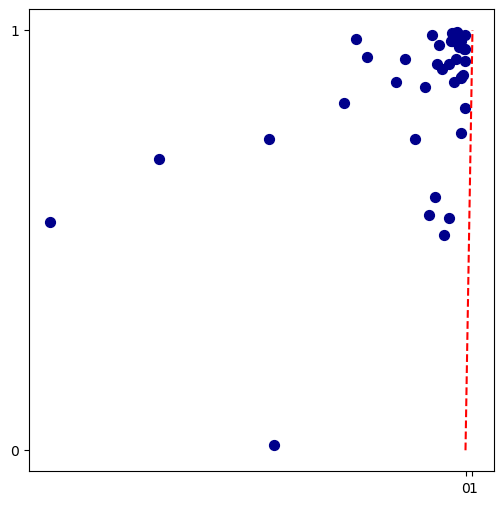

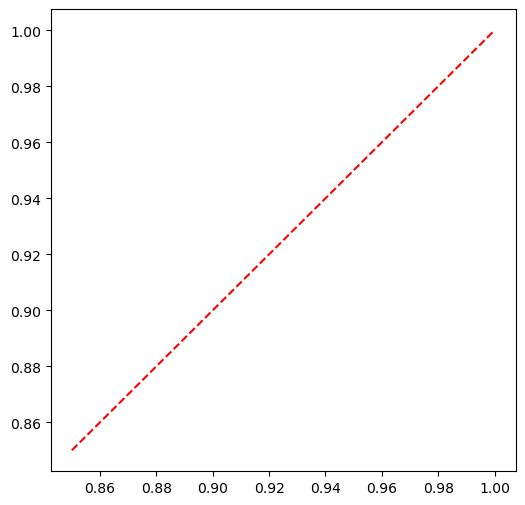

In [10]:
#Sample code for comparing DRL vs Open Loop RNN
#The code for complete analysis(vs EMG, Kinematics) is also given below

#
A_agent = np.concatenate((A_agent_s2, A_agent_s3, A_agent_s4, A_agent_s5, A_agent_s6), axis= 0)
A_exp = np.concatenate((A_exp_s2, A_exp_s3, A_exp_s4, A_exp_s5, A_exp_s6), axis=0)

reg_net = Ridge(alpha= 5e-02).fit(A_agent, A_exp)

pred_net = reg_net.predict(A_agent_s1)
print(r2_score(A_exp_s1, pred_net, multioutput= 'variance_weighted'))

r2_list = []

for k in range(pred_net.shape[1]):
    r_val = r2_score(A_exp_s1[:,k], pred_net[:, k])
    r2_list.append(r_val)
r2_array_net = np.array(r2_list)

A_RNN = np.concatenate((A_RNN_s2, A_RNN_s3, A_RNN_s4, A_RNN_s5, A_RNN_s6), axis= 0)
A_exp = np.concatenate((A_exp_s2, A_exp_s3, A_exp_s4, A_exp_s5, A_exp_s6), axis= 0)

reg_RNN = Ridge(alpha= 5e-02).fit(A_RNN, A_exp)
pred_RNN = reg_RNN.predict(A_RNN_s1)

print(r2_score(A_exp_s1, pred_RNN, multioutput= 'variance_weighted'))

r2_list = []

for k in range(pred_RNN.shape[1]):
    r_val = r2_score(A_exp_s1[:,k], pred_RNN[:, k])
    r2_list.append(r_val)
# print(r2_list)
r2_array_RNN = np.array(r2_list)

# -------------------- Plan of action ------------------------------
## Find r2_array_network and r2_array_emg. Find r2_array_network - r2_array_emg. Sort the resulting array in the
#  ascending order using argsort. Now plot the reconstructions in the ascending order using the already developed
# logic


### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_or(r2_array_net>=0, r2_array_RNN>=0))
filter2 = np.where(np.logical_and(r2_array_RNN>=0, r2_array_RNN<=1))
filter = np.intersect1d(filter1, filter2)

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_RNN[filter1], r2_array_net[filter1], s=50, c= 'darkblue')
plt.plot([0, 1], [0, 1], '--', c= 'r', linewidth= 1.5)

plt.xticks([0, 1], ['0', '1'], size= 10)
plt.yticks([0, 1], ['0', '1'], size= 10)
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/r2_comparison_s1_rnn.svg', format='svg', dpi=300, transparent= True)
plt.show()

### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_and(r2_array_net>=0.85, r2_array_net<=1))
filter2 = np.where(np.logical_and(r2_array_RNN>=0.85, r2_array_RNN<=1))
filter = np.intersect1d(filter1, filter2)

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_RNN[filter], r2_array_net[filter], s=50, c= 'darkblue')
plt.plot([0.85, 1], [0.85, 1], '--', c= 'r', linewidth= 1.5)

# plt.xticks([0, 1], ['0', '1'], size= 10)
# plt.yticks([0, 1], ['0', '1'], size= 10)
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/r2_comparison_s1_rnn_2.svg', format='svg', dpi=300, transparent= True)
plt.show()

R2 nuSim, Condition Train1 0.9780116361944575
R2 Open Loop RNN, Condition Train1 0.8495719489895228


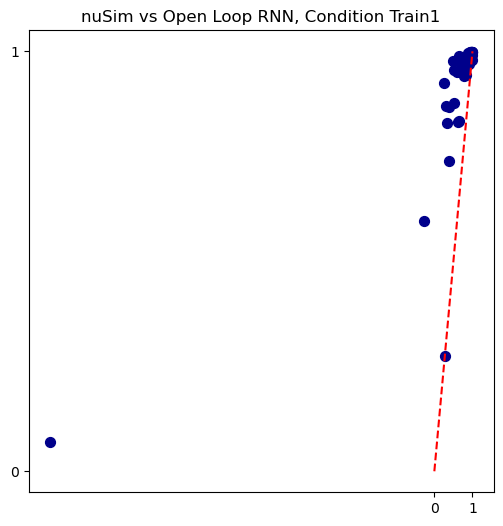

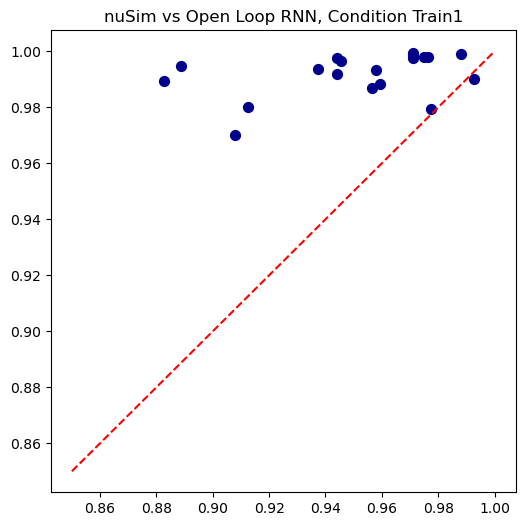

R2 nuSim, Condition Train2 0.9754805946873858
R2 Open Loop RNN, Condition Train2 0.9621371582062128


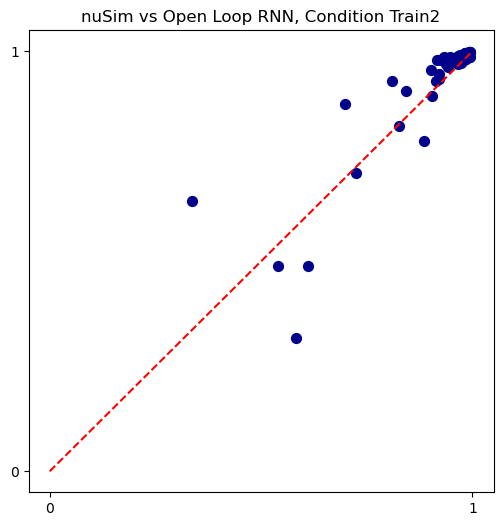

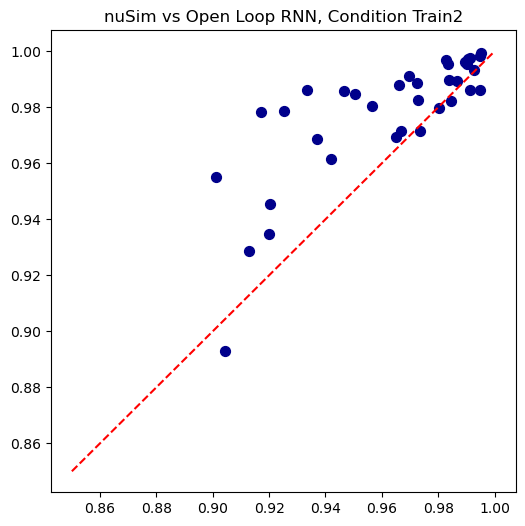

R2 nuSim, Condition Train3 0.9714847409619031
R2 Open Loop RNN, Condition Train3 0.9372738448958554


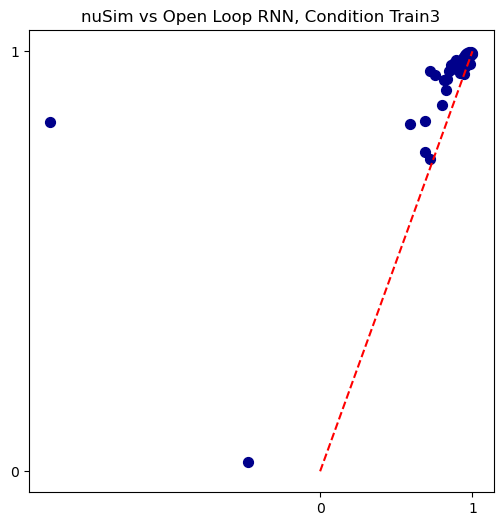

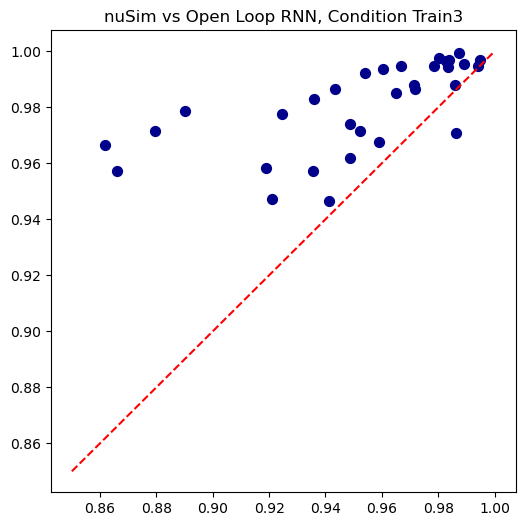

R2 nuSim, Condition Train4 0.6420178497169476
R2 Open Loop RNN, Condition Train4 0.511092889713275


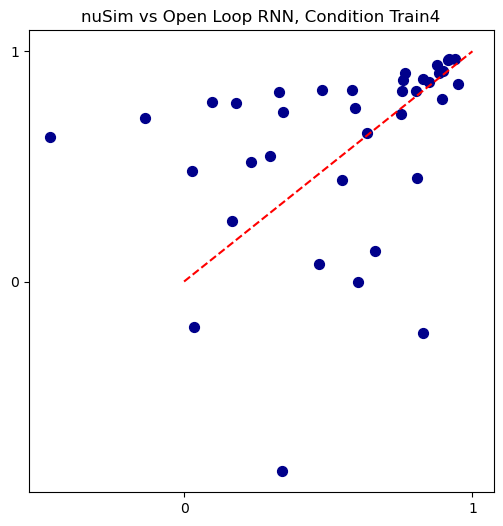

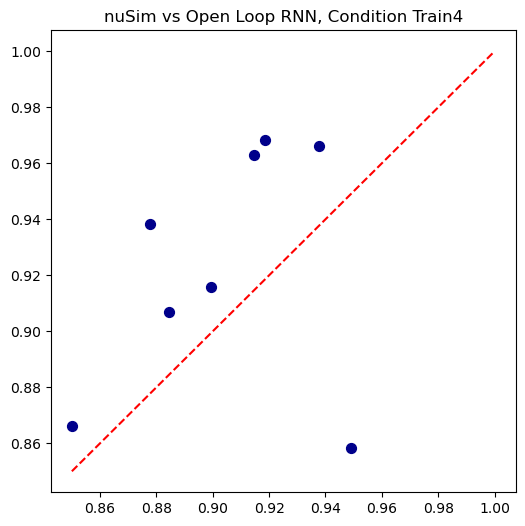

R2 nuSim, Condition Test1 0.9248596700931451
R2 Open Loop RNN, Condition Test1 -4.461028874916974


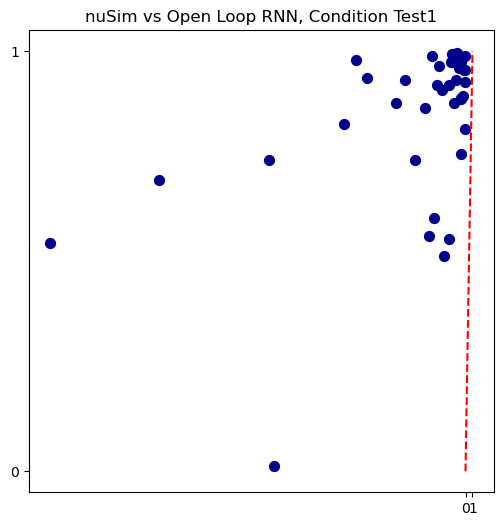

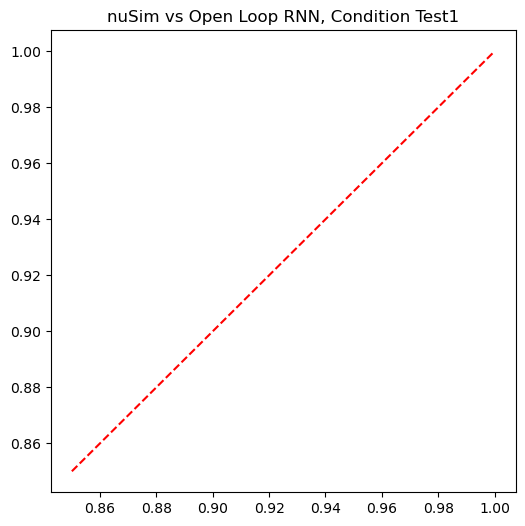

R2 nuSim, Condition Test2 0.9557011867795753
R2 Open Loop RNN, Condition Test2 -1.1169566642527267


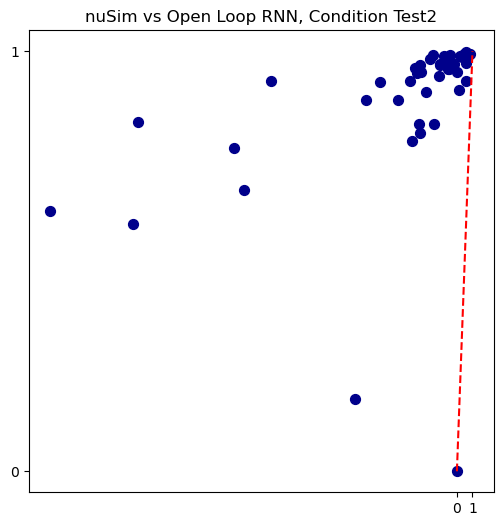

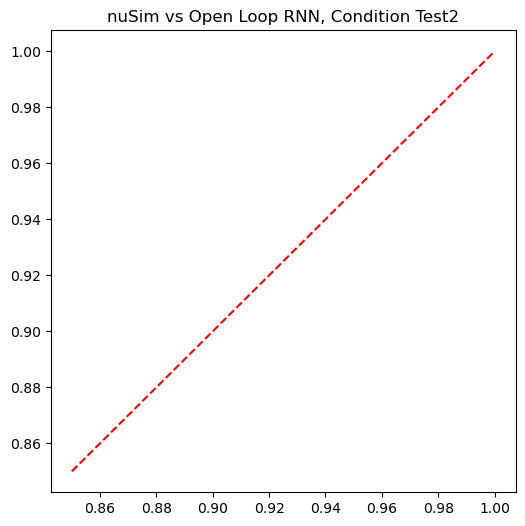

R2 nuSim, Condition Train1 0.9780116361944575
R2 EMG, Condition Train1 0.8789061505587537


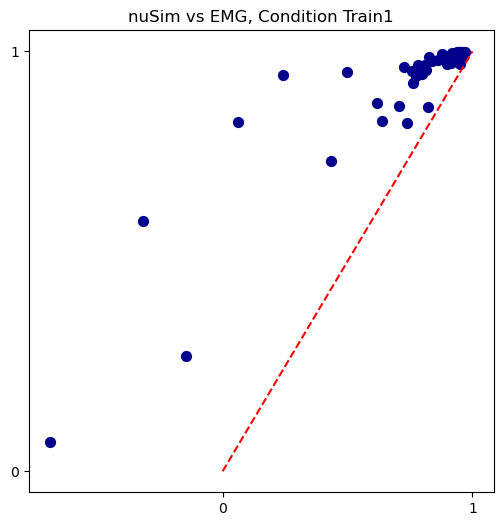

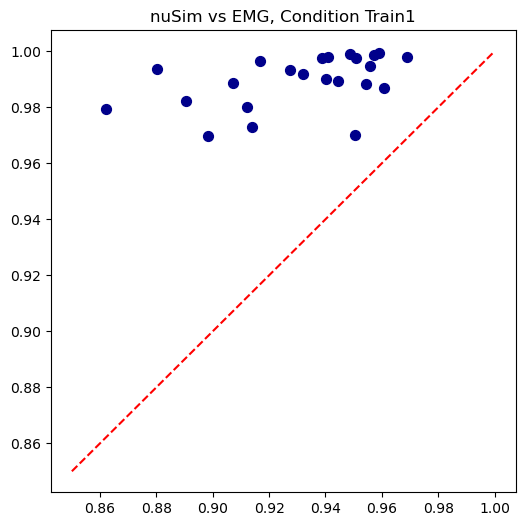

R2 nuSim, Condition Train2 0.9754805946873858
R2 EMG, Condition Train2 0.9072365891133923


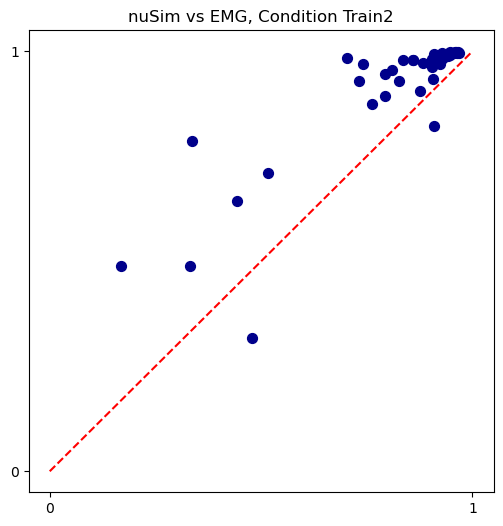

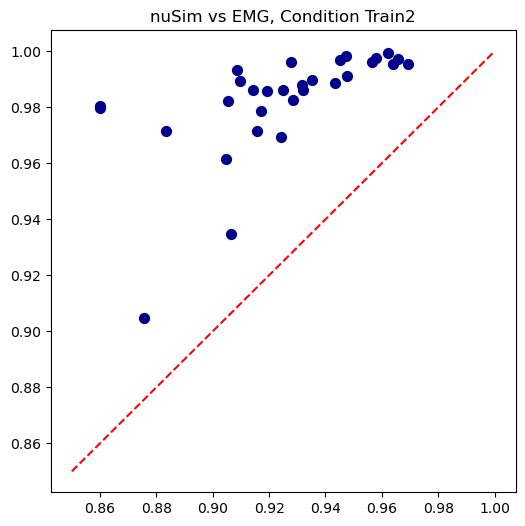

R2 nuSim, Condition Train3 0.9714847409619031
R2 EMG, Condition Train3 0.8786104254018511


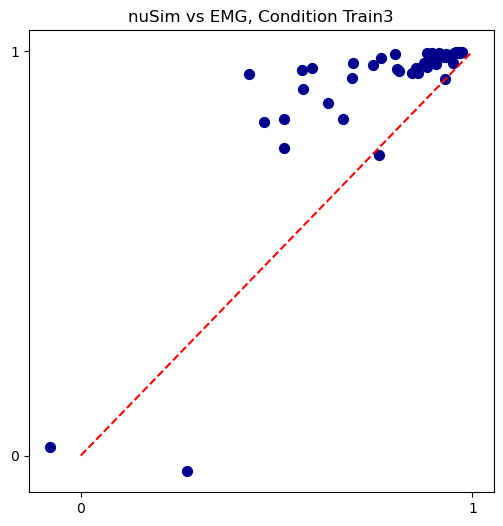

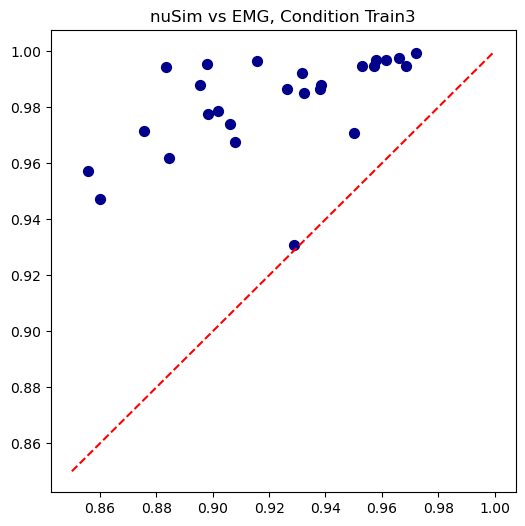

R2 nuSim, Condition Train4 0.6420178497169476
R2 EMG, Condition Train4 0.6702731900371596


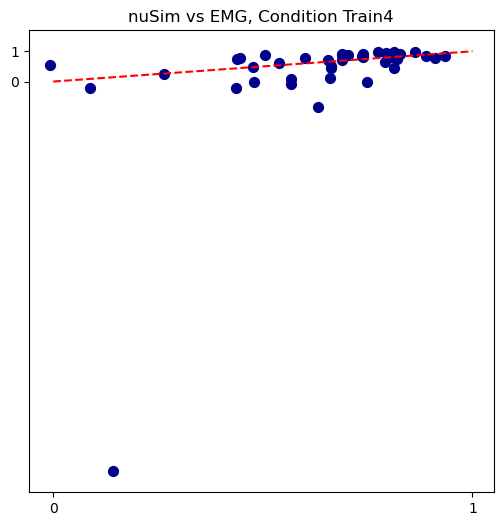

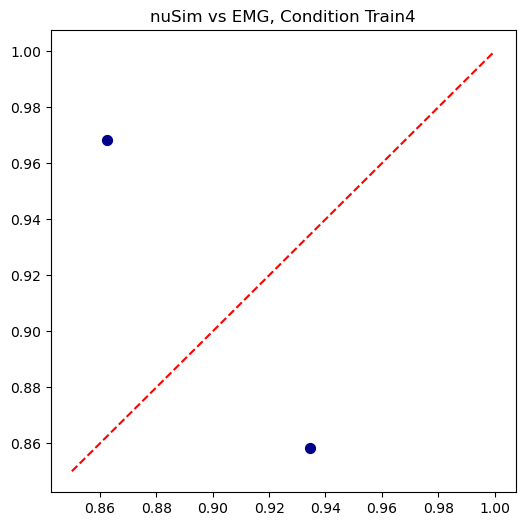

R2 nuSim, Condition Test1 0.9248596700931451
R2 EMG, Condition Test1 0.6245329881534161


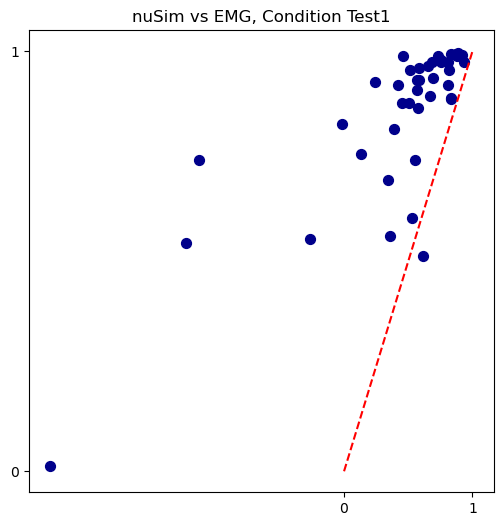

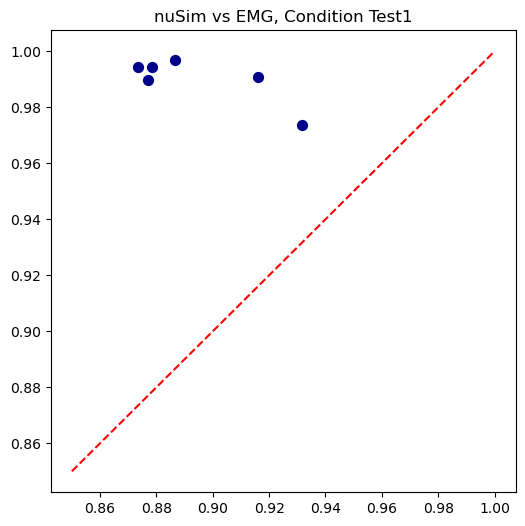

R2 nuSim, Condition Test2 0.9557011867795753
R2 EMG, Condition Test2 0.8998887033187078


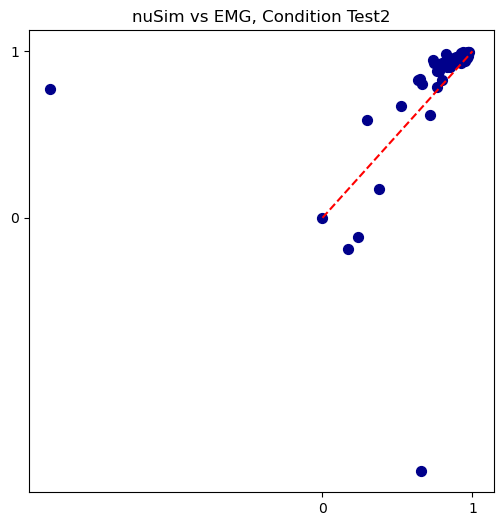

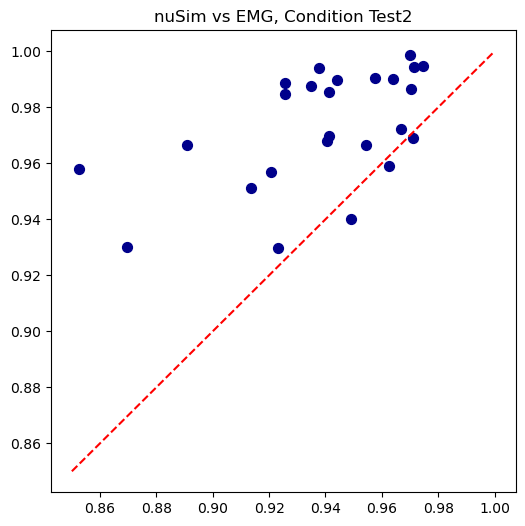

R2 nuSim, Condition Train1 0.9780116361944575
R2 Kinematics, Condition Train1 0.7701087787429126


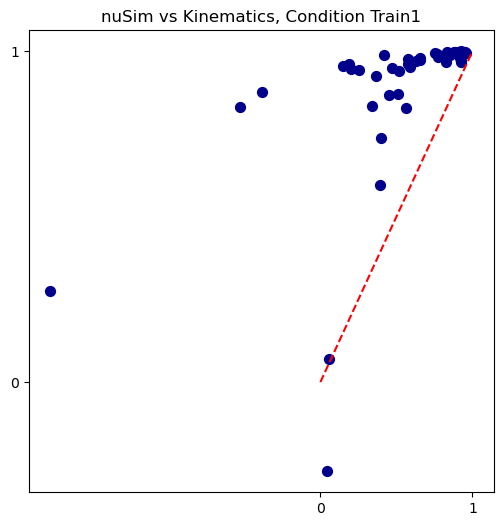

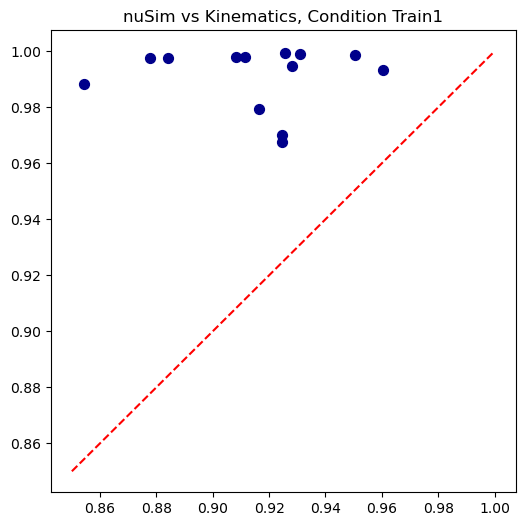

R2 nuSim, Condition Train2 0.9754805946873858
R2 Kinematics, Condition Train2 0.831614948718129


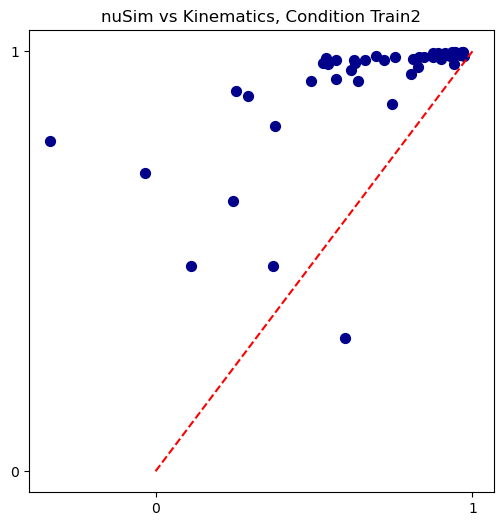

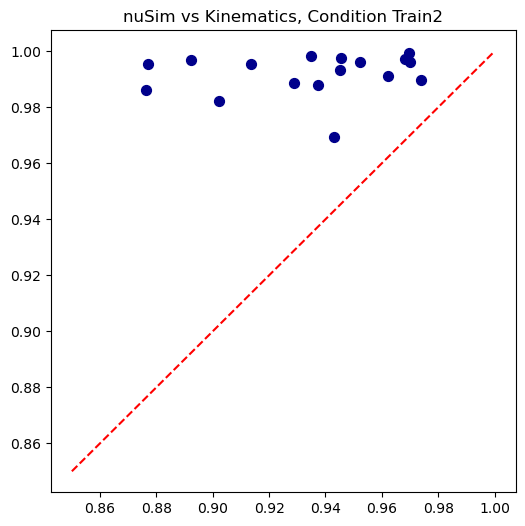

R2 nuSim, Condition Train3 0.9714847409619031
R2 Kinematics, Condition Train3 0.8260628638889259


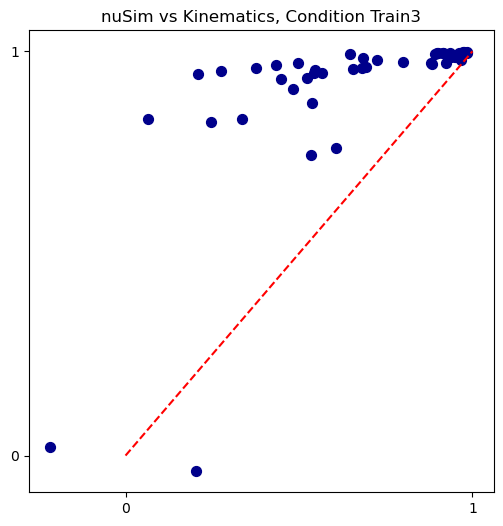

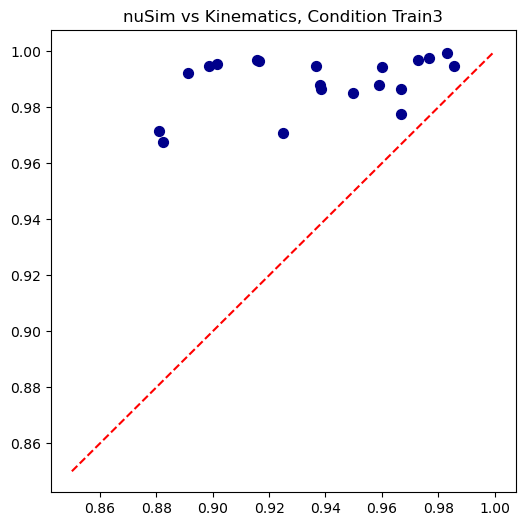

R2 nuSim, Condition Train4 0.6420178497169476
R2 Kinematics, Condition Train4 0.5917282000286103


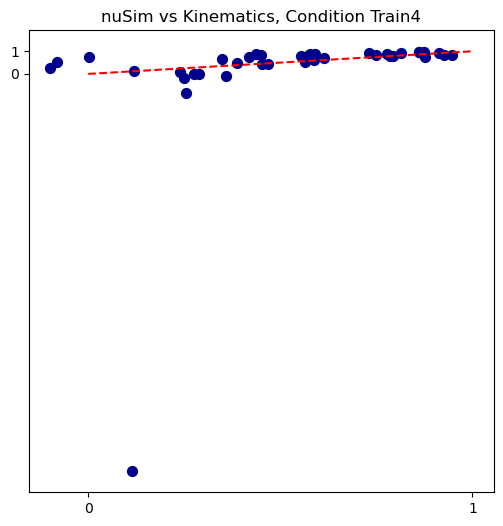

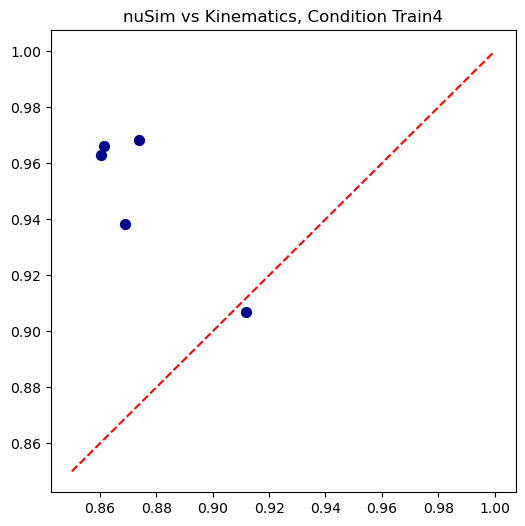

R2 nuSim, Condition Test1 0.9248596700931451
R2 Kinematics, Condition Test1 0.671065048328222


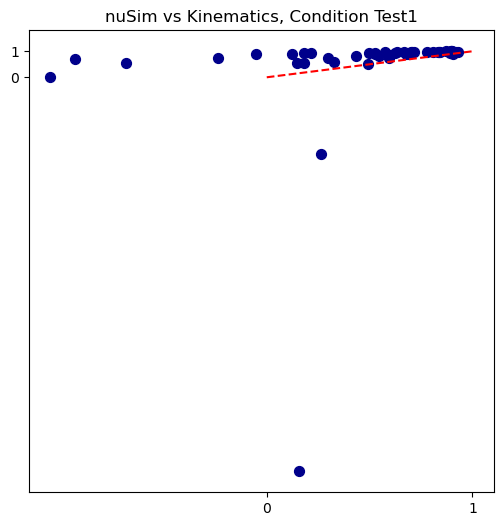

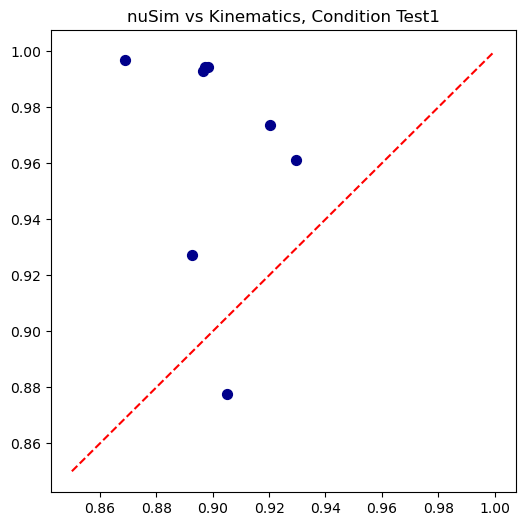

R2 nuSim, Condition Test2 0.9557011867795753
R2 Kinematics, Condition Test2 0.7790985858152499


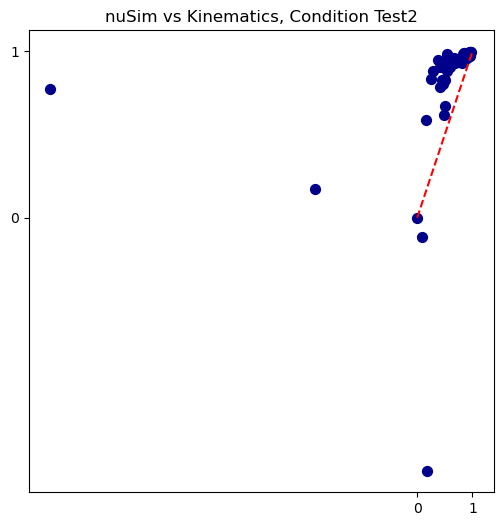

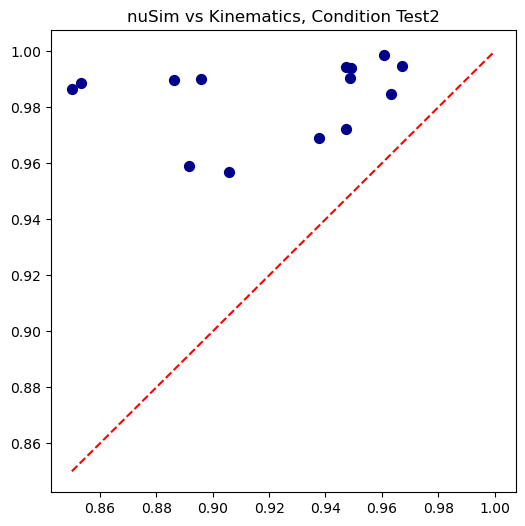

In [11]:
#Load emg for training and testing

#Assign the exp, nusim and other activities
#Merge both the training and testing activities dicts

#First make the keys of all testing different from training
for idx in range(len(exp_test)):
    #Exp
    exp_test[idx+len(exp_train)] = exp_test[idx]
    del exp_test[idx]

    #nuSim
    nusim_test[idx+len(nusim_train)] = nusim_test[idx]
    del nusim_test[idx]

    #emg
    emg_test[idx+len(emg_train)] = emg_test[idx]
    del emg_test[idx]

    #kinematics
    kin_test[idx+len(kin_train)] = kin_test[idx]
    del kin_test[idx]

    #rnn
    rnn_test[idx+len(rnn_train)] = rnn_test[idx]
    del rnn_test[idx]


A_exp_all = {**exp_train, **exp_test}
A_nusim_all ={**nusim_train, **nusim_test}

#Now carry this out for all the training and testing conditions
#i_cond is the held_out condition

#Repeat this for rnn, emg and kin
#Create an array representing all the conditions
A_other_all_models = [{**rnn_train, **rnn_test}, {**emg_train, **emg_test}, {**kin_train, **kin_test}]
model_names = ['Open Loop RNN', 'EMG', 'Kinematics']

for i_comparison in range(len(A_other_all_models)):

    A_other_all = A_other_all_models[i_comparison]

    for i_cond in range(len(A_exp_all)):

        A_exp_held_out = A_exp_all[i_cond]
        A_nusim_held_out = A_nusim_all[i_cond]
        A_other_held_out = A_other_all[i_cond]

        flag_first = 0
        #Concatenate the experimental, nusim and other comparative model activities
        for idx in range(len(A_exp_all)):

            if idx != i_cond:
                if flag_first == 0:
                    A_exp = A_exp_all[idx]

                    #Preprocess the nuSim activities as done with experimental preprocessing
                    A_nusim = A_nusim_all[idx]

                    A_other = A_other_all[idx]
                    flag_first = 1
                else:
                    A_exp = np.concatenate((A_exp, A_exp_all[idx]), axis= 0)
                    A_nusim = np.concatenate((A_nusim, A_nusim_all[idx]), axis= 0)
                    A_other = np.concatenate((A_other, A_other_all[idx]), axis= 0)


        # A_exp = np.concatenate((A_exp_702, A_exp_803, A_exp_932, A_exp_1106, A_exp_1319), axis=0)
        # A_nusim = np.concatenate((A_agent_702, A_agent_803, A_agent_932, A_agent_1106, A_agent_1319), axis= 0)

        reg_net = Ridge(alpha= 5e-02).fit(A_nusim, A_exp)
        #
        pred_nusim_held_out = reg_net.predict(A_nusim_held_out)

        if i_cond < len(nusim_train):
            print(f"R2 nuSim, Condition Train{i_cond+1}", r2_score(A_exp_held_out, pred_nusim_held_out, multioutput= 'variance_weighted'))
        else:
            print(f"R2 nuSim, Condition Test{i_cond+1-len(nusim_train)}", r2_score(A_exp_held_out, pred_nusim_held_out, multioutput= 'variance_weighted'))

        r2_list = []

        for k in range(pred_nusim_held_out.shape[1]):
            r_val = r2_score(A_exp_held_out[:,k], pred_nusim_held_out[:, k])
            r2_list.append(r_val)

        r2_array_nusim = np.array(r2_list)

        # A_other = np.concatenate((A_RNN_702, A_RNN_803, A_RNN_932, A_RNN_1106, A_RNN_1319), axis= 0)

        reg_other = Ridge(alpha= 5e-02).fit(A_other, A_exp)
        pred_other_held_out = reg_other.predict(A_other_held_out)

        if i_cond < len(nusim_train):
            print(f"R2 {model_names[i_comparison]}, Condition Train{i_cond+1}", r2_score(A_exp_held_out, pred_other_held_out, multioutput= 'variance_weighted'))
        else:
            print(f"R2 {model_names[i_comparison]}, Condition Test{i_cond+1-len(nusim_train)}", r2_score(A_exp_held_out, pred_other_held_out, multioutput= 'variance_weighted'))


        r2_list = []

        for k in range(pred_other_held_out.shape[1]):
            r_val = r2_score(A_exp_held_out[:,k], pred_other_held_out[:, k])
            r2_list.append(r_val)
        # print(r2_list)
        r2_array_other = np.array(r2_list)

        r2_diff = r2_array_nusim - r2_array_other
        # Change the order of the diff sort to go from the highest to the lowest index
        diff_sort = np.flip(np.argsort(r2_diff))

        ## Now use the diff_sort and pred_net and pred_emg to plot the activities of the neurons for which
        ## we have highest difference

        # plt.figure(figsize= (15, 15))

        # for idx, k in enumerate(diff_sort[:10]):
        #     # print(k)
        #     plt.plot(pred_nusim_held_out[:, k]/5 + idx*30, linewidth=3.0, c=(50/255, 205/255, 50/255))
        #     plt.plot(pred_other_held_out[:, k]/5 + idx*30, linewidth=3.0, c=(102/255, 102/255, 0/255))
        #     plt.plot(A_exp_held_out[:, k]/5 + idx*30, linewidth=3.0, c = 'k')

        # plt.ylabel('Reconstructed M1 Activity', size=14)
        # plt.xticks([])
        # plt.yticks([])
        # # plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/lin_net_vs_kin_932.eps', format='eps', dpi=600)

        # plt.show()

        ### ------------- Plot the scatter plot ------------------------------------------------------
        filter1 = np.where(np.logical_or(r2_array_nusim>=0, r2_array_other>=0))

        plt.figure(figsize= (6, 6))

        plt.scatter(r2_array_other[filter1], r2_array_nusim[filter1], s=50, c= 'darkblue')
        plt.plot([0, 1], [0, 1], '--', c= 'r', linewidth= 1.5)

        plt.xticks([0, 1], ['0', '1'], size= 10)
        plt.yticks([0, 1], ['0', '1'], size= 10)
        if i_cond < len(nusim_train):
            plt.title(f"nuSim vs {model_names[i_comparison]}, Condition Train{i_cond+1}")
        else:
            plt.title(f"nuSim vs {model_names[i_comparison]}, Condition Test{i_cond+1-len(nusim_train)}")
        # plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/r2_comparison_619_rnn.svg', format='svg', dpi=300, transparent= True)
        plt.show()

        ### ------------- Plot the scatter plot ------------------------------------------------------
        filter1 = np.where(np.logical_and(r2_array_nusim>=0.85, r2_array_nusim<=1))
        filter2 = np.where(np.logical_and(r2_array_other>=0.85, r2_array_other<=1))
        filter = np.intersect1d(filter1, filter2)

        plt.figure(figsize= (6, 6))

        plt.scatter(r2_array_other[filter], r2_array_nusim[filter], s=50, c= 'darkblue')
        plt.plot([0.85, 1], [0.85, 1], '--', c= 'r', linewidth= 1.5)

        # plt.xticks([0, 1], ['0', '1'], size= 10)
        # plt.yticks([0, 1], ['0', '1'], size= 10)
        if i_cond < len(nusim_train):
            plt.title(f"nuSim vs {model_names[i_comparison]}, Condition Train{i_cond+1}")
        else:
            plt.title(f"nuSim vs {model_names[i_comparison]}, Condition Test{i_cond+1-len(nusim_train)}")
        # plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/r2_comparison_619_rnn_2.eps', format='svg', dpi=300, transparent= True)
        plt.show()